In [1]:
pip install --upgrade keras-cv-attention-models


In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
import warnings
import time

warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("=" * 70)
print("DENSENET-121 (LATEST) + SWIN-T ENSEMBLE")
print("=" * 70)

# =====================================================================
# STAGE 1: DATA LOADING
# =====================================================================
def load_malaria_data():
    (train_data, info) = tfds.load(
        'malaria', split='train', with_info=True, as_supervised=True
    )
    total_samples = info.splits['train'].num_examples
    train_size = int(0.7 * total_samples)
    val_size = int(0.2 * total_samples)
    train_data = train_data.take(train_size)
    val_test_data = tfds.load('malaria', split='train', as_supervised=True).skip(train_size)
    val_data = val_test_data.take(val_size)
    test_data = val_test_data.skip(val_size)
    return train_data, val_data, test_data, total_samples

def preprocess_image(image, label, target_size=224):
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    return image, label

print("\n[STAGE 1] Loading and Preprocessing Data...")
stage1_start = time.time()
train_data, val_data, test_data, total_samples = load_malaria_data()
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size
print(f"✓ Total samples: {total_samples}")
print(f"✓ Train: {train_size}, Val: {val_size}, Test: {test_size}")

batch_size = 32
train_ds = train_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
stage1_end = time.time()

# =====================================================================
# STAGE 2A: FEATURE EXTRACTORS
# =====================================================================
print("\n[STAGE 2A] Building Feature Extractors...")
stage2a_start = time.time()

# DenseNet-121 extractor
def create_densenet121_extractor(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.DenseNet121(
        input_shape=input_shape, include_top=False, weights='imagenet'
    )
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda z: z * 255.0)(inputs)
    # wrap preprocess_input to keep it Keras-graph safe
    x = layers.Lambda(lambda z: tf.keras.applications.densenet.preprocess_input(z))(x)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return Model(inputs, x, name="DenseNet121_Extractor")

# Swin-Tiny (SwinTransformerV2 Tiny window=8) via keras-cv-attention-models
def create_swint_extractor(input_shape=(224, 224, 3)):
    from keras_cv_attention_models import swin_transformer_v2 as sv2
    backbone = sv2.SwinTransformerV2Tiny_window8(pretrained="imagenet", input_shape=input_shape)

    # Freeze most layers; unfreeze the last ~30 for partial fine-tuning
    for layer in backbone.layers[:-30]:
        layer.trainable = False
    for layer in backbone.layers[-30:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda img: img * 255.0)(inputs)
    x = backbone(x, training=True)
    # If backbone returns feature maps, GAP; if it returns a pooled vector, GAP is harmless.
    x = layers.GlobalAveragePooling2D()(x) if len(x.shape) == 4 else x
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return Model(inputs=inputs, outputs=x, name="SwinT_Extractor")

densenet_extractor = create_densenet121_extractor()
swint_extractor = create_swint_extractor()

print(f"✓ DenseNet121 params: {densenet_extractor.count_params():,}")
print(f"✓ Swin-T params: {swint_extractor.count_params():,}")

# =====================================================================
# STAGE 2B: FINE-TUNE
# =====================================================================
def fine_tune_extractors(train_ds, val_ds, epochs=10):
    for extractor in [densenet_extractor, swint_extractor]:
        temp_input = layers.Input(shape=(224, 224, 3))
        features = extractor(temp_input)
        logits = layers.Dense(2)(features)
        model = Model(temp_input, logits)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        print(f"\nFine-tuning {extractor.name}...")
        model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

fine_tune_extractors(train_ds, val_ds)

# =====================================================================
# STAGE 2C: FEATURE EXTRACTION
# =====================================================================
def extract_features(model, dataset):
    feats, labels = [], []
    for imgs, lbls in dataset:
        f = model(imgs, training=False)
        feats.append(f.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(feats), np.concatenate(labels)

print("\nExtracting DenseNet features...")
train_dense, train_lbls = extract_features(densenet_extractor, train_ds)
val_dense, val_lbls = extract_features(densenet_extractor, val_ds)
test_dense, test_lbls = extract_features(densenet_extractor, test_ds)

print("Extracting Swin-T features...")
train_swin, _ = extract_features(swint_extractor, train_ds)
val_swin, _ = extract_features(swint_extractor, val_ds)
test_swin, _ = extract_features(swint_extractor, test_ds)

print(f"DenseNet shape: {train_dense.shape}")
print(f"Swin-T shape: {train_swin.shape}")

# =====================================================================
# STAGE 3: FUSION
# =====================================================================
train_emb = np.concatenate([train_dense, train_swin], axis=1)
val_emb = np.concatenate([val_dense, val_swin], axis=1)
test_emb = np.concatenate([test_dense, test_swin], axis=1)

fusion_lr = LogisticRegression(max_iter=1000).fit(train_emb, train_lbls)
fcn = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])
fcn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fcn.fit(train_emb, train_lbls, validation_data=(val_emb, val_lbls), epochs=30, batch_size=32, verbose=1)

# =====================================================================
# STAGE 4: EVALUATION (unchanged)
# =====================================================================
def evaluate_fusion(embeddings, labels, fusion_model):
    if isinstance(fusion_model, LogisticRegression):
        preds = fusion_model.predict(embeddings)
        probs = fusion_model.predict_proba(embeddings)
    else:
        probs = fusion_model.predict(embeddings, verbose=0)
        preds = np.argmax(probs, axis=1)
    return {
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "auc": roc_auc_score(labels, probs[:, 1])
    }

print("\nTest Results:")
lr_res = evaluate_fusion(test_emb, test_lbls, fusion_lr)
fcn_res = evaluate_fusion(test_emb, test_lbls, fcn)
print(f"LogReg → ACC: {lr_res['acc']:.4f}, F1: {lr_res['f1']:.4f}, AUC: {lr_res['auc']:.4f}")
print(f"FCN   → ACC: {fcn_res['acc']:.4f}, F1: {fcn_res['f1']:.4f}, AUC: {fcn_res['auc']:.4f}")


DENSENET-121 (LATEST) + SWIN-T ENSEMBLE

[STAGE 1] Loading and Preprocessing Data...
✓ Total samples: 27558
✓ Train: 19290, Val: 5511, Test: 2757

[STAGE 2A] Building Feature Extractors...
 27262976/114320936 [======>.......................] - ETA: 12s[Error] will not load weights, url not found or download failed: https://github.com/leondgarse/keras_cv_attention_models/releases/download/swin_transformer_v2/swin_transformer_v2_tiny_window8_256_imagenet.h5
✓ DenseNet121 params: 7,562,304
✓ Swin-T params: 28,859,666

Fine-tuning DenseNet121_Extractor...
Epoch 1/10


KeyboardInterrupt: 

DENSENET-121 (LATEST) + SWIN-T ENSEMBLE

[STAGE 1] Loading and Preprocessing Data...
✓ Total samples: 27558
✓ Train: 19290 (70%)
✓ Val: 5511 (20%)
✓ Test: 2757 (10%)

[STAGE 2A] Building Feature Extractors...
⏱ Stage 1 Time: 0.14 seconds

114320936/114320936 [==============================] - 210s 2us/step
>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_window8_256_imagenet.h5
✓ DenseNet121 Extractor: 7,562,304 parameters
✓ Swin-T Extractor: 28,859,666 parameters

[STAGE 2B] Partially Fine-tuning Models...

✓ Fine-tuning DenseNet121_Extractor...
  Trainable params in DenseNet121_Extractor: 0
Epoch 1/15
603/603 [==============================] - 104s 146ms/step - loss: 0.7240 - accuracy: 0.6215 - val_loss: 0.6931 - val_accuracy: 0.6431
Epoch 2/15
603/603 [==============================] - 84s 139ms/step - loss: 0.6931 - accuracy: 0.6256 - val_loss: 0.6931 - val_accuracy: 0.6436
Epoch 3/15
603/603 [==============================] - 84s 139ms/step - loss: 0.6931 - 

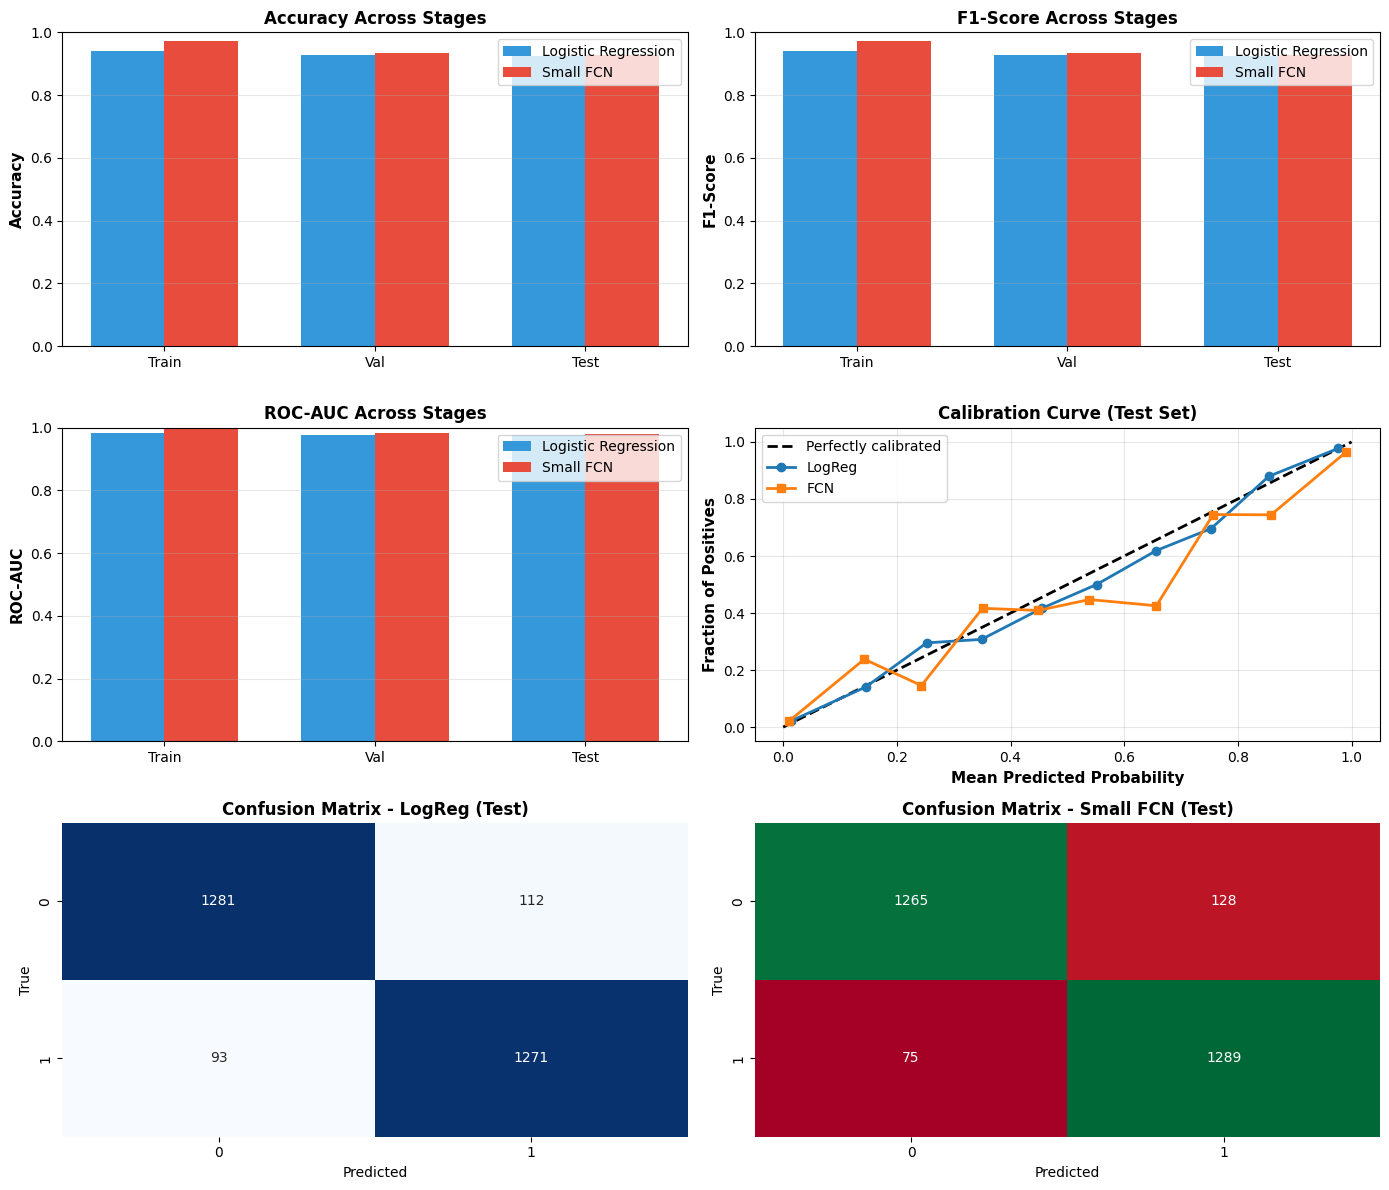

In [4]:
# ======================= MUST BE FIRST LINES =======================
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
# ==================================================================

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
import warnings
import time

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 70)
print("DENSENET-121 (LATEST) + SWIN-T ENSEMBLE")
print("=" * 70)

# ============================================================================
# STAGE 1: LOAD AND PREPROCESS DATA (70/20/10 split)
# ============================================================================
print("\n[STAGE 1] Loading and Preprocessing Data...")
stage1_start = time.time()

def load_malaria_data():
    """Load malaria dataset with 70/20/10 split"""
    (train_data, info) = tfds.load(
        'malaria',
        split='train',
        with_info=True,
        as_supervised=True
    )

    total_samples = info.splits['train'].num_examples
    train_size = int(0.7 * total_samples)
    val_size = int(0.2 * total_samples)

    train_data = train_data.take(train_size)
    val_test_data = tfds.load('malaria', split='train', as_supervised=True).skip(train_size)
    val_data = val_test_data.take(val_size)
    test_data = val_test_data.skip(val_size)

    return train_data, val_data, test_data, total_samples

def preprocess_image(image, label, target_size=224):
    """Preprocess image for both DenseNet121 and Swin-T"""
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    return image, label

# Load data
train_data, val_data, test_data, total_samples = load_malaria_data()

train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

print(f"✓ Total samples: {total_samples}")
print(f"✓ Train: {train_size} (70%)")
print(f"✓ Val: {val_size} (20%)")
print(f"✓ Test: {test_size} (10%)")

# Preprocess datasets
batch_size = 32
train_ds = train_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ============================================================================
# STAGE 2A: BUILD MODELS WITH FEATURE EXTRACTORS
# ============================================================================
print("\n[STAGE 2A] Building Feature Extractors...")
stage1_end = time.time()
print(f"⏱ Stage 1 Time: {stage1_end - stage1_start:.2f} seconds\n")
stage2a_start = time.time()

# -------------------- DenseNet121 extractor --------------------
def create_densenet121_extractor(input_shape=(224, 224, 3)):
    """DenseNet121 with frozen backbone, partially fine-tunable top layers"""
    base_model = tf.keras.applications.DenseNet121(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze most layers, unfreeze last ~30 for partial fine-tuning
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    # Graph-safe preprocessing
    x = layers.Lambda(lambda z: z * 255.0)(inputs)
    x = layers.Lambda(lambda z: tf.keras.applications.densenet.preprocess_input(z))(x)
    x = base_model(x, training=None)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    model = Model(inputs=inputs, outputs=x, name='DenseNet121_Extractor')
    return model

# -------------------- Swin-T (SwinTransformerV2 Tiny win=8) extractor --------------------
def create_swint_extractor(input_shape=(224, 224, 3)):
    """Swin Transformer V2 Tiny (window=8) with partial fine-tuning"""
    from keras_cv_attention_models import swin_transformer_v2 as sv2

    backbone = sv2.SwinTransformerV2Tiny_window8(
        pretrained="imagenet",
        input_shape=input_shape
    )

    # Freeze most layers, unfreeze last ~30 for partial fine-tuning
    for layer in backbone.layers[:-30]:
        layer.trainable = False
    for layer in backbone.layers[-30:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda img: img * 255.0)(inputs)  # graph-safe scaling
    x = backbone(x, training=None)
    # If backbone returns feature maps: GAP; if it returns a pooled vector, GAP is harmless.
    x = layers.GlobalAveragePooling2D()(x) if len(x.shape) == 4 else x
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    model = Model(inputs=inputs, outputs=x, name='SwinT_Extractor')
    return model

densenet_extractor = create_densenet121_extractor()
swint_extractor = create_swint_extractor()

print(f"✓ DenseNet121 Extractor: {densenet_extractor.count_params():,} parameters")
print(f"✓ Swin-T Extractor: {swint_extractor.count_params():,} parameters")

# ============================================================================
# STAGE 2B: PARTIALLY FINE-TUNE MODELS
# ============================================================================
print("\n[STAGE 2B] Partially Fine-tuning Models...")

def fine_tune_extractors(train_ds, val_ds, epochs=15):
    """Partially fine-tune feature extractors using classification objective"""
    for extractor in [densenet_extractor, swint_extractor]:
        # Create temporary model with classification head for fine-tuning only
        temp_input = layers.Input(shape=(224, 224, 3))
        features = extractor(temp_input)
        logits = layers.Dense(2, name='temp_classification_head')(features)
        temp_model = Model(inputs=temp_input, outputs=logits)

        temp_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        print(f"\n✓ Fine-tuning {extractor.name}...")
        print(f"  Trainable params in {extractor.name}: ", end="")
        # count trainable params belonging to densenet or swint parts
        trainable_count = sum([
            tf.size(w).numpy() for w in temp_model.trainable_weights
            if ('densenet' in w.name.lower()) or ('swin' in w.name.lower())
        ])
        print(f"{trainable_count:,}")

        history = temp_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1
        )
        print(f"  Final train loss: {history.history['loss'][-1]:.4f}, "
              f"val loss: {history.history['val_loss'][-1]:.4f}")

fine_tune_extractors(train_ds, val_ds, epochs=15)
stage2b_end = time.time()

# ============================================================================
# STAGE 2C: EXTRACT FEATURES (without classification head)
# ============================================================================
print("\n[STAGE 2C] Extracting Features from Fine-tuned Models...")
stage2c_start = time.time()

def extract_features(model, dataset):
    """Extract features from dataset using fine-tuned extractor"""
    features_list, labels_list = [], []
    for images, labels in dataset:
        features = model(images, training=False)
        features_list.append(features.numpy())
        labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

print("✓ Extracting DenseNet121 features...")
train_dense, train_labels = extract_features(densenet_extractor, train_ds)
val_dense, val_labels = extract_features(densenet_extractor, val_ds)
test_dense, test_labels = extract_features(densenet_extractor, test_ds)

print("✓ Extracting Swin-T features...")
train_swin, _ = extract_features(swint_extractor, train_ds)
val_swin, _ = extract_features(swint_extractor, val_ds)
test_swin, _ = extract_features(swint_extractor, test_ds)

print(f"✓ DenseNet121 feature shape: {train_dense.shape}")
print(f"✓ Swin-T feature shape: {train_swin.shape}")

stage2c_end = time.time()
print(f"⏱ Stage 2C Time: {stage2c_end - stage2c_start:.2f} seconds")

# ============================================================================
# STAGE 3: FUSE EMBEDDINGS
# ============================================================================
print("\n[STAGE 3] Fusing Embeddings...")
stage3_start = time.time()

# Concatenate embeddings from both models
train_embeddings = np.concatenate([train_dense, train_swin], axis=1)
val_embeddings = np.concatenate([val_dense, val_swin], axis=1)
test_embeddings = np.concatenate([test_dense, test_swin], axis=1)

print(f"✓ Fused embedding shape: {train_embeddings.shape}")

# Fusion Method 1: Logistic Regression
print("\n[FUSION 1] Training Logistic Regression...")
lr_start = time.time()
fusion_lr = LogisticRegression(max_iter=1000, random_state=42, verbose=0)
fusion_lr.fit(train_embeddings, train_labels)
lr_end = time.time()
print(f"✓ Logistic Regression fusion completed")
print(f"  ⏱ LogReg Training Time: {lr_end - lr_start:.2f} seconds")

# Fusion Method 2: Small FCN
print("\n[FUSION 2] Training Small FCN...")
fcn_model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

fcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

fcn_start = time.time()
history_fcn = fcn_model.fit(
    train_embeddings, train_labels,
    validation_data=(val_embeddings, val_labels),
    epochs=30,
    batch_size=32,
    verbose=1
)
fcn_end = time.time()
print(f"✓ Small FCN fusion completed - Final val accuracy: {history_fcn.history['val_accuracy'][-1]:.4f}")
print(f"  ⏱ FCN Training Time: {fcn_end - fcn_start:.2f} seconds")

stage3_end = time.time()
print(f"\n⏱ Stage 3 Total Time: {stage3_end - stage3_start:.2f} seconds")

# ============================================================================
# STAGE 4: EVALUATE MODELS
# ============================================================================
print("\n[STAGE 4] Evaluation Metrics...")
stage4_start = time.time()

def evaluate_fusion(embeddings, labels, fusion_model, method_name):
    """Comprehensive evaluation with accuracy, F1-score, AUC, calibration, confusion"""

    if isinstance(fusion_model, LogisticRegression):
        predictions = fusion_model.predict(embeddings)
        probabilities = fusion_model.predict_proba(embeddings)
    else:  # FCN model
        probabilities = fusion_model.predict(embeddings, verbose=0)
        predictions = np.argmax(probabilities, axis=1)

    # Metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    auc = roc_auc_score(labels, probabilities[:, 1])

    # Calibration curve
    frac_pos, mean_pred = calibration_curve(labels, probabilities[:, 1], n_bins=10)

    # Confusion matrix
    cm = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
        'calibration': (frac_pos, mean_pred),
        'confusion_matrix': cm,
        'predictions': predictions,
        'probabilities': probabilities
    }

print("\n" + "="*70)
print("LOGISTIC REGRESSION FUSION RESULTS")
print("="*70)
train_metrics_lr = evaluate_fusion(train_embeddings, train_labels, fusion_lr, "LogReg")
val_metrics_lr = evaluate_fusion(val_embeddings, val_labels, fusion_lr, "LogReg")
test_metrics_lr = evaluate_fusion(test_embeddings, test_labels, fusion_lr, "LogReg")

print(f"\nTraining Set:")
print(f"  ✓ Accuracy: {train_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {train_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {train_metrics_lr['auc']:.4f}")

print(f"\nValidation Set:")
print(f"  ✓ Accuracy: {val_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {val_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {val_metrics_lr['auc']:.4f}")

print(f"\nTest Set:")
print(f"  ✓ Accuracy: {test_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {test_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {test_metrics_lr['auc']:.4f}")

print("\n" + "="*70)
print("SMALL FCN FUSION RESULTS")
print("="*70)
train_metrics_fcn = evaluate_fusion(train_embeddings, train_labels, fcn_model, "FCN")
val_metrics_fcn = evaluate_fusion(val_embeddings, val_labels, fcn_model, "FCN")
test_metrics_fcn = evaluate_fusion(test_embeddings, test_labels, fcn_model, "FCN")

print(f"\nTraining Set:")
print(f"  ✓ Accuracy: {train_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {train_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {train_metrics_fcn['auc']:.4f}")

print(f"\nValidation Set:")
print(f"  ✓ Accuracy: {val_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {val_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {val_metrics_fcn['auc']:.4f}")

print(f"\nTest Set:")
print(f"  ✓ Accuracy: {test_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {test_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {test_metrics_fcn['auc']:.4f}")

stage4_end = time.time()
print(f"\n⏱ Stage 4 Time: {stage4_end - stage4_start:.2f} seconds")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\nGenerating visualizations...")
viz_start = time.time()

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Accuracy comparison
stages = ['Train', 'Val', 'Test']
acc_lr = [train_metrics_lr['accuracy'], val_metrics_lr['accuracy'], test_metrics_lr['accuracy']]
acc_fcn = [train_metrics_fcn['accuracy'], val_metrics_fcn['accuracy'], test_metrics_fcn['accuracy']]

x = np.arange(len(stages))
width = 0.35
axes[0, 0].bar(x - width/2, acc_lr, width, label='Logistic Regression', color='#3498db')
axes[0, 0].bar(x + width/2, acc_fcn, width, label='Small FCN', color='#e74c3c')
axes[0, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Accuracy Across Stages', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(stages)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# F1-Score comparison
f1_lr = [train_metrics_lr['f1'], val_metrics_lr['f1'], test_metrics_lr['f1']]
f1_fcn = [train_metrics_fcn['f1'], val_metrics_fcn['f1'], test_metrics_fcn['f1']]

axes[0, 1].bar(x - width/2, f1_lr, width, label='Logistic Regression', color='#3498db')
axes[0, 1].bar(x + width/2, f1_fcn, width, label='Small FCN', color='#e74c3c')
axes[0, 1].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('F1-Score Across Stages', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(stages)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# ROC-AUC comparison
auc_lr = [train_metrics_lr['auc'], val_metrics_lr['auc'], test_metrics_lr['auc']]
auc_fcn = [train_metrics_fcn['auc'], val_metrics_fcn['auc'], test_metrics_fcn['auc']]

axes[1, 0].bar(x - width/2, auc_lr, width, label='Logistic Regression', color='#3498db')
axes[1, 0].bar(x + width/2, auc_fcn, width, label='Small FCN', color='#e74c3c')
axes[1, 0].set_ylabel('ROC-AUC', fontsize=11, fontweight='bold')
axes[1, 0].set_title('ROC-AUC Across Stages', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(stages)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Calibration curves (Test set)
frac_pos_lr, mean_pred_lr = test_metrics_lr['calibration']
frac_pos_fcn, mean_pred_fcn = test_metrics_fcn['calibration']

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
axes[1, 1].plot(mean_pred_lr, frac_pos_lr, 'o-', label='LogReg', linewidth=2, markersize=6)
axes[1, 1].plot(mean_pred_fcn, frac_pos_fcn, 's-', label='FCN', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Fraction of Positives', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Calibration Curve (Test Set)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Confusion matrices (Test set)
cm_lr = test_metrics_lr['confusion_matrix']
cm_fcn = test_metrics_fcn['confusion_matrix']

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[2, 0], cbar=False)
axes[2, 0].set_title('Confusion Matrix - LogReg (Test)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Predicted')
axes[2, 0].set_ylabel('True')

sns.heatmap(cm_fcn, annot=True, fmt='d', cmap='RdYlGn', ax=axes[2, 1], cbar=False)
axes[2, 1].set_title('Confusion Matrix - Small FCN (Test)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Predicted')
axes[2, 1].set_ylabel('True')

plt.tight_layout()
plt.savefig('ensemble_evaluation.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved as 'ensemble_evaluation.png'")

viz_end = time.time()
print(f"⏱ Visualization Time: {viz_end - viz_start:.2f} seconds")

print("\n" + "=" * 70)
print("ENSEMBLE TRAINING AND EVALUATION COMPLETED!")
print("=" * 70)

# Total timing summary
total_time = viz_end - stage1_start

print("\n" + "=" * 70)
print("⏱ TIMING SUMMARY")
print("=" * 70)
print(f"\nStage 1 (Data Loading & Preprocessing): {stage1_end - stage1_start:.2f} seconds")
print(f"Stage 2A-2B (Build & Fine-tune Models): {stage2b_end - stage2a_start:.2f} seconds")
print(f"Stage 2C (Feature Extraction): {stage2c_end - stage2c_start:.2f} seconds")
print(f"Stage 3 (Embedding Fusion): {stage3_end - stage3_start:.2f} seconds")
print(f"Stage 4 (Evaluation): {stage4_end - stage4_start:.2f} seconds")
print(f"Visualization: {viz_end - viz_start:.2f} seconds")

print(f"\n{'='*70}")
print(f"TOTAL PIPELINE TIME: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"{'='*70}")
